In [48]:
pip install scikit-fuzzy


In [49]:
pip install deap

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from scipy.optimize import differential_evolution
import random
import math
from deap import base, creator, tools, algorithms

In [51]:
# Part 1: Fuzzy Logic Controller (FLC) Design and Implementation #

# Define input variables
error = ctrl.Antecedent(np.arange(-10, 11, 1), 'error')
change_in_error = ctrl.Antecedent(np.arange(-5, 6, 1), 'change_in_error')


In [9]:
# Define output variable
output = ctrl.Consequent(np.arange(-1, 2, 1), 'output')

In [10]:
# Define membership functions for input variables
error['negative'] = fuzz.trimf(error.universe, [-10, -5, 0])
error['zero'] = fuzz.trimf(error.universe, [-5, 0, 5])
error['positive'] = fuzz.trimf(error.universe, [0, 5, 10])

In [11]:
change_in_error['negative'] = fuzz.trimf(change_in_error.universe, [-5, -3, 0])
change_in_error['zero'] = fuzz.trimf(change_in_error.universe, [-3, 0, 3])
change_in_error['positive'] = fuzz.trimf(change_in_error.universe, [0, 3, 5])

In [12]:
# Define membership functions for output variable
output['low'] = fuzz.trimf(output.universe, [-1, -1, 0])
output['medium'] = fuzz.trimf(output.universe, [-1, 0, 1])
output['high'] = fuzz.trimf(output.universe, [0, 1, 1])

In [13]:
# Define fuzzy rules
rule1 = ctrl.Rule(error['negative'] & change_in_error['negative'], output['low'])
rule2 = ctrl.Rule(error['zero'] | change_in_error['zero'], output['medium'])
rule3 = ctrl.Rule(error['positive'] & change_in_error['positive'], output['high'])

In [14]:
# Create fuzzy control system
flc_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
flc = ctrl.ControlSystemSimulation(flc_ctrl)

In [15]:
# Sample input values
flc.input['error'] = -3
flc.input['change_in_error'] = 2

In [16]:
# Compute FLC output
flc.compute()


In [17]:
# Print FLC output
print("FLC Output:", flc.output['output'])

FLC Output: -2.1684043449710086e-17


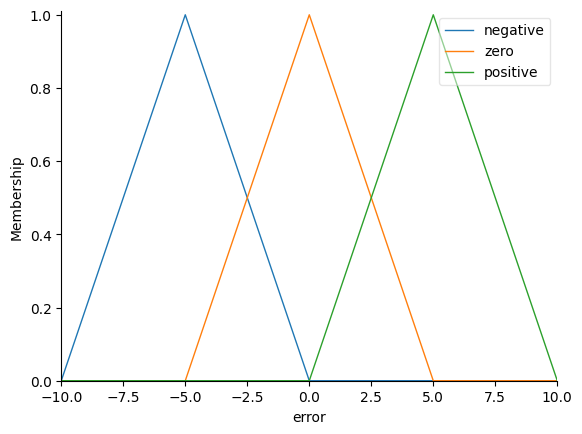

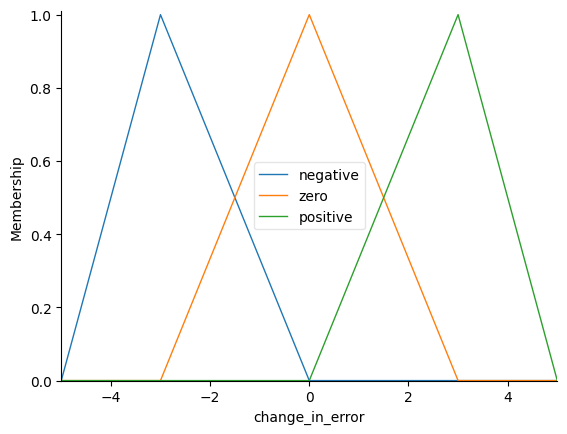

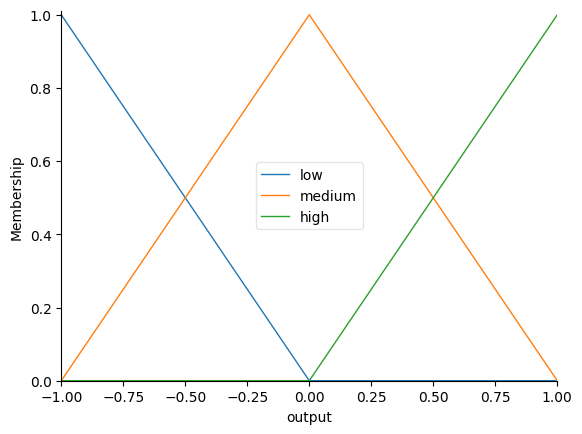

In [18]:
# Visualize membership functions
error.view()
change_in_error.view()
output.view()
plt.show()

In [19]:
# Part 2: FLC Optimization using Genetic Algorithm #

# Define the problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

In [20]:
# Number of parameters to optimize (length of chromosome)
num_params = len(error.terms.values()) + len(change_in_error.terms.values()) + len(output.terms.values())

In [21]:
# Initialize the genetic algorithm parameters
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, num_params)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [36]:
def evaluate_fitness(params):
    # Update membership functions with the parameters
    update_membership_functions(params)

    # Initialize the fuzzy control system simulation
    local_flc_ctrl = ctrl.ControlSystemSimulation(flc_ctrl)

    # Initialize variables for simulation
    num_samples = 100
    temperature_setpoint = 25  # Desired room temperature
    temperature_deviation_sum = 0

    # Simulate the FLC over multiple samples
    for _ in range(num_samples):
        # Generate random error and change_in_error values for simulation
        local_flc_ctrl.input['error'] = random.uniform(-10, 10)
        local_flc_ctrl.input['change_in_error'] = random.uniform(-5, 5)

        # Debugging: Print input values before computing
        print("Input Values:", local_flc_ctrl.input)

        try:
            # Compute FLC output
            local_flc_ctrl.compute()
        except Exception as e:
            print("Error during computation:", e)
            print("Params:", params)
            print("Input Values:", local_flc_ctrl.input)
            raise e

        # Debugging: Print output value after computing
        print("Output Value:", local_flc_ctrl.output['output'])

        # Get the simulated output and calculate temperature deviation
        simulated_output = local_flc_ctrl.output['output']
        temperature_deviation = abs(simulated_output - temperature_setpoint)
        temperature_deviation_sum += temperature_deviation

    # Calculate the average temperature deviation as the fitness
    average_temperature_deviation = temperature_deviation_sum / num_samples

    return average_temperature_deviation,


In [37]:
# ... (remaining code)
def update_membership_functions(params):
    # Extract parameters and update membership functions accordingly
    num_error_terms = len(error.terms)
    num_change_in_error_terms = len(change_in_error.terms)
    num_output_terms = len(output.terms)

    # Extract parameters for error membership functions
    error_params = params[:num_error_terms]
    for i, term in enumerate(error.terms.values()):
        term.mf = error_params[i]

    # Extract parameters for change_in_error membership functions
    change_in_error_params = params[num_error_terms:num_error_terms + num_change_in_error_terms]
    for i, term in enumerate(change_in_error.terms.values()):
        term.mf = change_in_error_params[i]

    # Extract parameters for output membership functions
    output_params = params[num_error_terms + num_change_in_error_terms:]
    for i, term in enumerate(output.terms.values()):
        term.mf = output_params[i]

In [42]:
# Main genetic algorithm loop
def main():
    population_size = 50
    generations = 20

    # Create an initial population
    population = toolbox.population(n=population_size)

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Crossover and mutate for specified generations
    for generation in range(generations):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring + population, k=population_size)



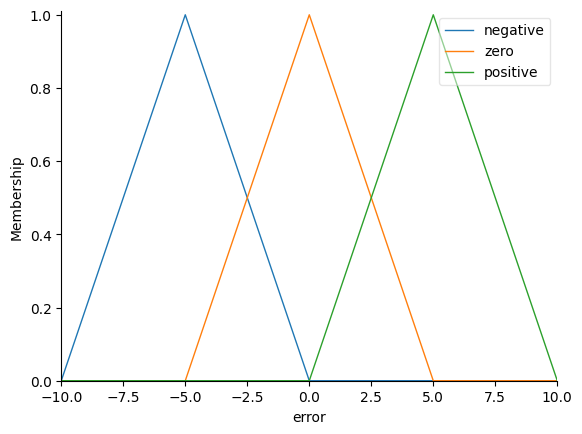

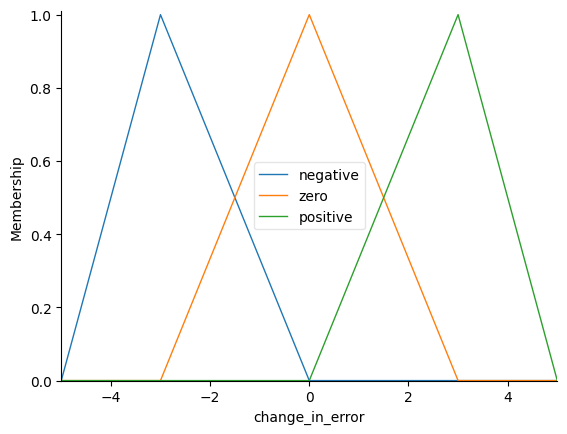

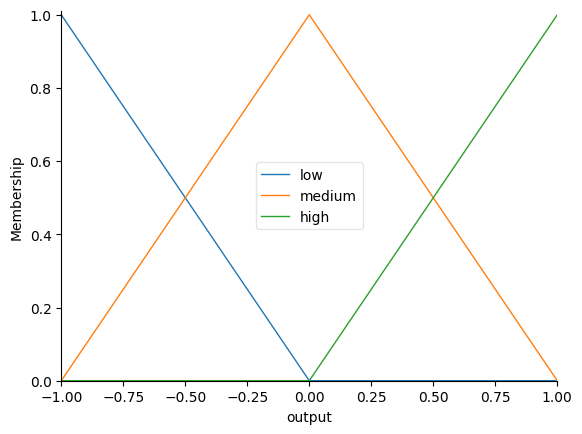

In [46]:
    # Visualize the optimized membership functions (optional)
    error.view()
    change_in_error.view()
    output.view()
    plt.show()
